In [1]:
import pandas as pd
import time
from nba_api.stats.endpoints import boxscoretraditionalv3 as box
from nba_api.stats.endpoints import leaguegamelog as lgl
from scipy.stats import poisson
import numpy as np
import matplotlib.pyplot as plt

In [90]:
# headers = {
#     'Host': 'stats.nba.com',
#     'Connection': 'keep-alive',
#     'Cache-Control': 'max-age=0',
#     'Upgrade-Insecure-Requests': '1',
#     'User-Agent': 'Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/144.0.0.0 Safari/537.36',
#     'Accept': 'text/html,application/xhtml+xml,application/xml;q=0.9,image/webp,image/apng,*/*;q=0.8,application/signed-exchange;v=b3',
#     'Accept-Encoding': 'gzip, deflate, br',
#     'Accept-Language': 'en-US,en;q=0.9',
# }

In [3]:
game_ids_call = lgl.LeagueGameLog(date_to_nullable='2026-01-18').get_data_frames()[0]

In [4]:
game_ids_call.sort_values('GAME_DATE').tail()

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
1254,22025,1610612745,HOU,Houston Rockets,0022500604,2026-01-18,HOU vs. NOP,W,240,45,...,30,47,22,9,4,15,12,119,9,1
1252,22025,1610612753,ORL,Orlando Magic,0022500602,2026-01-18,ORL @ MEM,L,240,42,...,30,42,30,5,6,17,20,109,-17,1
1262,22025,1610612761,TOR,Toronto Raptors,0022500607,2026-01-18,TOR @ LAL,L,240,38,...,33,43,30,7,5,10,15,93,-17,1
1256,22025,1610612740,NOP,New Orleans Pelicans,0022500604,2026-01-18,NOP @ HOU,L,240,44,...,29,39,27,10,5,14,16,110,-9,1
1263,22025,1610612763,MEM,Memphis Grizzlies,0022500602,2026-01-18,MEM @ ORL,W,240,48,...,33,42,31,12,7,12,18,126,17,1


In [11]:
game_ids_call[game_ids_call['GAME_ID'].isin(missing)]

,SEASON_ID,TEAM_ID,TEAM_ABBREVIATION,TEAM_NAME,GAME_ID,GAME_DATE,MATCHUP,WL,MIN,FGM,...,DREB,REB,AST,STL,BLK,TOV,PF,PTS,PLUS_MINUS,VIDEO_AVAILABLE
1198,22025,1610612743,DEN,Denver Nuggets,0022500575,2026-01-14,DEN @ DAL,W,240,42,...,32,39,21,4,1,9,25,118,9,1
1199,22025,1610612742,DAL,Dallas Mavericks,0022500575,2026-01-14,DAL vs. DEN,L,240,41,...,34,47,16,6,3,6,20,109,-9,1
1200,22025,1610612746,LAC,LA Clippers,0022500577,2026-01-14,LAC vs. WAS,W,240,39,...,33,40,25,9,5,10,14,119,14,1
1201,22025,1610612764,WAS,Washington Wizards,0022500577,2026-01-14,WAS @ LAC,L,240,41,...,30,41,25,5,3,11,17,105,-14,1
1204,22025,1610612763,MEM,Memphis Grizzlies,0022500578,2026-01-15,MEM @ ORL,L,240,38,...,30,37,27,5,6,16,18,111,-7,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1259,22025,1610612758,SAC,Sacramento Kings,0022500606,2026-01-18,SAC vs. POR,L,240,42,...,30,40,29,8,5,16,26,110,-7,1
1260,22025,1610612757,POR,Portland Trail Blazers,0022500606,2026-01-18,POR @ SAC,W,240,40,...,32,43,18,7,4,15,18,117,7,1
1261,22025,1610612747,LAL,Los Angeles Lakers,0022500607,2026-01-18,LAL vs. TOR,W,240,41,...,39,48,25,6,6,15,15,110,17,1
1262,22025,1610612761,TOR,Toronto Raptors,0022500607,2026-01-18,TOR @ LAL,L,240,38,...,33,43,30,7,5,10,15,93,-17,1


In [5]:
game_ids = game_ids_call['GAME_ID'].unique().tolist()

In [12]:
stats = []

for i in missing:
    game = box.BoxScoreTraditionalV3(i, timeout=100).get_dict()
    
    for team_key in ['homeTeam', 'awayTeam']:
        team_data = game['boxScoreTraditional'][team_key]
        is_home = 1 if team_key == 'homeTeam' else 0
        for player in team_data['players']:
            player_info = {
                'gameId': game['boxScoreTraditional']['gameId'],
                'teamId': team_data['teamId'],
                'teamCity': team_data['teamCity'],
                'teamName': team_data['teamName'],
                'isHome': is_home,
                'playerId': player['personId'],
                'firstName': player['firstName'],
                'lastName': player['familyName'],
                'position': player['position'],
                'jerseyNum': player['jerseyNum']
            }
            row = {**player_info, **player['statistics']}
            stats.append(row)

    time.sleep(.5)

stats_df = pd.DataFrame(stats)

In [8]:
missing = list(set(game_ids_call['GAME_ID'].unique()) - set(prep_df['gameId'].unique()))

In [7]:
# prep_df = pd.DataFrame(stats)

In [17]:
# prep_df = pd.concat([prep_df,stats_df/).drop_duplicates()

In [18]:
unfinished_df = prep_df.merge(game_ids_call[['GAME_ID', 'GAME_DATE']], how = 'left', left_on='gameId', right_on='GAME_ID').drop(columns='GAME_ID')

In [20]:
unfinished_df.to_parquet("game_logs.parquet",index=False)

In [99]:
unfinished_df["minutes"] = unfinished_df["minutes"].str.strip()
unfinished_df["minutes"] = unfinished_df["minutes"].replace("", "0:00")

In [100]:
mins_secs = unfinished_df["minutes"].str.split(":", expand=True).astype(int)
unfinished_df["minutes_decimal"] = mins_secs[0] + mins_secs[1] / 60

In [103]:
unfinished_df.describe().columns

Index(['teamId', 'isHome', 'playerId', 'fieldGoalsMade', 'fieldGoalsAttempted',
       'fieldGoalsPercentage', 'threePointersMade', 'threePointersAttempted',
       'threePointersPercentage', 'freeThrowsMade', 'freeThrowsAttempted',
       'freeThrowsPercentage', 'reboundsOffensive', 'reboundsDefensive',
       'reboundsTotal', 'assists', 'steals', 'blocks', 'turnovers',
       'foulsPersonal', 'points', 'plusMinusPoints', 'minutes_decimal'],
      dtype='object')

In [104]:
unfinished_df['ppm'] = unfinished_df['points'] / unfinished_df['minutes_decimal']
unfinished_df['FGMpm'] = unfinished_df['fieldGoalsMade'] / unfinished_df['minutes_decimal']
unfinished_df['FGApm'] = unfinished_df['fieldGoalsAttempted'] / unfinished_df['minutes_decimal']
unfinished_df['3Mpm'] = unfinished_df['threePointersMade'] / unfinished_df['minutes_decimal']
unfinished_df['3Apm'] = unfinished_df['threePointersAttempted'] / unfinished_df['minutes_decimal']
unfinished_df['FTMpm'] = unfinished_df['freeThrowsMade'] / unfinished_df['minutes_decimal']
unfinished_df['FTApm'] = unfinished_df['freeThrowsAttempted'] / unfinished_df['minutes_decimal']
unfinished_df['orpm'] = unfinished_df['reboundsOffensive'] / unfinished_df['minutes_decimal']
unfinished_df['drpm'] = unfinished_df['reboundsDefensive'] / unfinished_df['minutes_decimal']
unfinished_df['rpm'] = unfinished_df['reboundsTotal'] / unfinished_df['minutes_decimal']
unfinished_df['apm'] = unfinished_df['assists'] / unfinished_df['minutes_decimal']
unfinished_df['spm'] = unfinished_df['steals'] / unfinished_df['minutes_decimal']
unfinished_df['bpm'] = unfinished_df['blocks'] / unfinished_df['minutes_decimal']
unfinished_df['topm'] = unfinished_df['turnovers'] / unfinished_df['minutes_decimal']
unfinished_df['fpm'] = unfinished_df['foulsPersonal'] / unfinished_df['minutes_decimal']

In [117]:
unfinished_df

,gameId,teamId,teamCity,teamName,isHome,playerId,firstName,lastName,position,jerseyNum,...,FTMpm,FTApm,orpm,drpm,rpm,apm,spm,bpm,topm,fpm
0,0022500002,1610612747,Los Angeles,Lakers,1,1630559,Austin,Reaves,F,,...,0.192661,0.275229,0.027523,0.110092,0.137615,0.247706,0.055046,0.000000,0.137615,0.137615
1,0022500002,1610612747,Los Angeles,Lakers,1,1629060,Rui,Hachimura,F,,...,0.000000,0.000000,0.000000,0.112941,0.112941,0.084706,0.000000,0.000000,0.028235,0.056471
2,0022500002,1610612747,Los Angeles,Lakers,1,1629028,Deandre,Ayton,C,,...,0.000000,0.059026,0.059026,0.118052,0.177078,0.000000,0.000000,0.029513,0.118052,0.088539
3,0022500002,1610612747,Los Angeles,Lakers,1,1629216,Gabe,Vincent,G,,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.034803,0.034803,0.000000,0.000000,0.104408
4,0022500002,1610612747,Los Angeles,Lakers,1,1629029,Luka,Dončić,G,,...,0.170801,0.244002,0.000000,0.292802,0.292802,0.219601,0.048800,0.024400,0.073200,0.024400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15660,0022500575,1610612743,Denver,Nuggets,0,1628971,Bruce,Brown,,,...,0.042343,0.084686,0.084686,0.127029,0.211715,0.042343,0.000000,0.000000,0.042343,0.127029
15661,0022500575,1610612743,Denver,Nuggets,0,1641747,DaRon,Holmes II,,,...,0.000000,0.000000,0.000000,0.437956,0.437956,0.000000,0.000000,0.000000,0.000000,0.218978
15662,0022500575,1610612743,Denver,Nuggets,0,1642938,Curtis,Jones,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15663,0022500575,1610612743,Denver,Nuggets,0,1631124,Julian,Strawther,,,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [55]:
# !git clone https://github.com/LarryLoveIV/NBA-PropFinder.git

In [56]:
# !mv game_logs.parquet NBA-PropFinder/

In [54]:
# %cd NBA-PropFinder

# !git status
# !git add game_logs.parquet
# !git commit -m "Add NBA game logs parquet file"
# !git push

In [51]:
# !git config --global user.name "Larry Love IV"
# !git config --global user.email "lawrenceloveiv@gmail.com"

In [52]:
# !git add game_logs.parquet

In [53]:
# !git status

In [46]:
# !git commit -m "Add game logs parquet file"

In [47]:
# !git branch -M main

In [49]:
# !git push -u origin main

In [50]:
# !git remote set-url origin https://github.com/LarryLoveIV/NBA-PropFinder.git

In [30]:
df = pd.read_parquet("game_logs.parquet")

In [77]:
grimes_df = df[df['lastName']=='Bailey']

In [78]:
grimes_df['firstName'].unique()

array(['Ace'], dtype=object)

In [79]:
grimes_df.describe()

,teamId,isHome,playerId,fieldGoalsMade,fieldGoalsAttempted,fieldGoalsPercentage,threePointersMade,threePointersAttempted,threePointersPercentage,freeThrowsMade,...,reboundsOffensive,reboundsDefensive,reboundsTotal,assists,steals,blocks,turnovers,foulsPersonal,points,plusMinusPoints
count,3.400000e+01,34.000000,34.0,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,...,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000,34.000000
mean,1.610613e+09,0.529412,1642846.0,3.823529,8.735294,0.399588,1.323529,3.882353,0.257382,0.647059,...,1.382353,1.705882,3.088235,1.500000,0.676471,0.352941,1.088235,2.264706,9.617647,-4.294118
std,0.000000e+00,0.506640,0.0,2.380102,3.971938,0.171539,1.364498,2.625801,0.261193,0.949716,...,1.155086,1.291685,1.864625,1.261312,0.842816,0.691172,1.083419,1.657103,6.203688,11.435006
min,1.610613e+09,0.000000,1642846.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-23.000000
25%,1.610613e+09,0.000000,1642846.0,2.000000,5.000000,0.333000,0.000000,2.000000,0.000000,0.000000,...,1.000000,1.000000,2.000000,0.000000,0.000000,0.000000,0.000000,1.000000,5.000000,-15.750000
50%,1.610613e+09,1.000000,1642846.0,4.000000,9.000000,0.414500,1.000000,3.500000,0.268000,0.000000,...,1.000000,1.000000,3.000000,1.000000,0.500000,0.000000,1.000000,2.000000,9.500000,-1.500000
75%,1.610613e+09,1.000000,1642846.0,5.750000,12.000000,0.500000,2.750000,6.000000,0.475000,1.750000,...,2.000000,2.000000,4.000000,3.000000,1.000000,0.750000,2.000000,3.000000,13.000000,5.000000
max,1.610613e+09,1.000000,1642846.0,8.000000,15.000000,0.667000,4.000000,8.000000,1.000000,3.000000,...,4.000000,5.000000,8.000000,4.000000,3.000000,3.000000,3.000000,6.000000,21.000000,14.000000


In [80]:
# λ = mean points per game
lambda_pts = grimes_df['points'].mean()
print(f"Poisson λ (average points): {lambda_pts}")

# Use mean ± 4*sqrt(lambda) as a practical range
# Poisson variance = λ, so std = sqrt(λ)
upper = int(lambda_pts + 4*np.sqrt(lambda_pts))
lower = 0  # points can’t be negative
points_range = np.arange(lower, upper + 1)


# Poisson probability mass function
poisson_probs = poisson.pmf(points_range, lambda_pts)

# Example: probability LeBron scores exactly 28 points
prob_28 = poisson.pmf(28, lambda_pts)
print(f"Probability of exactly 28 points: {prob_28:.2%}")

Poisson λ (average points): 9.617647058823529
Probability of exactly 28 points: 0.00%


In [82]:
points = 15
over_prob = 1 - poisson.cdf(points, lambda_pts)  # >28 points
under_prob = poisson.cdf(points, lambda_pts)     # ≤28 points

print(f"Probability over {points} points: {over_prob:.2%}")
print(f"Probability under {points} points: {under_prob:.2%}")

Probability over 15 points: 3.67%
Probability under 15 points: 96.33%


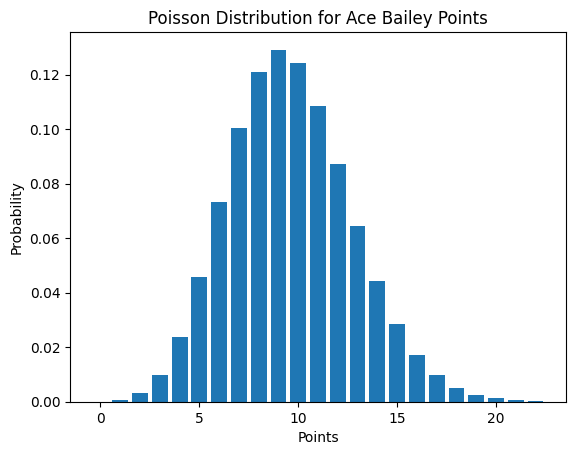

In [85]:
plt.bar(points_range, poisson_probs)
plt.xlabel("Points")
plt.ylabel("Probability")
plt.title("Poisson Distribution for Ace Bailey Points")
plt.show()

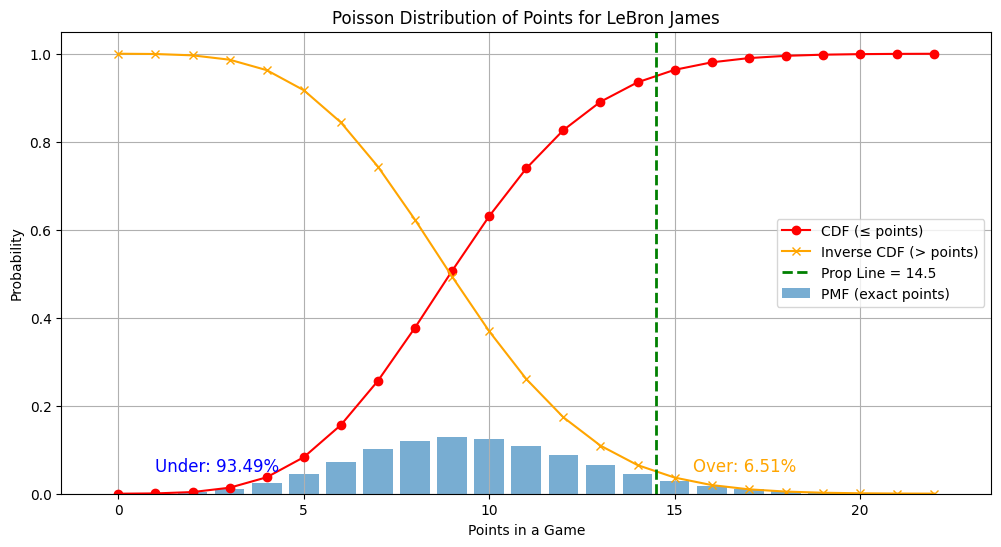

In [89]:
# Example: LeBron James averages 27 points
lambda_pts = grimes_df['points'].mean()
prop_line = 14.5  # example prop line

# Set a realistic range: mean ± 4*sqrt(lambda)
lower = 0
upper = int(lambda_pts + 4 * np.sqrt(lambda_pts))
points_range = np.arange(lower, upper + 1)

# PMF: probability of exactly k points
pmf_vals = poisson.pmf(points_range, lambda_pts)

# CDF: cumulative probability (≤ k points)
cdf_vals = poisson.cdf(points_range, lambda_pts)

# Inverse CDF: probability of > k points (right tail)
inv_cdf_vals = 1 - cdf_vals

# Plotting
plt.figure(figsize=(12,6))

# PMF bars
plt.bar(points_range, pmf_vals, alpha=0.6, label='PMF (exact points)')

# CDF line
plt.plot(points_range, cdf_vals, color='red', marker='o', label='CDF (≤ points)')

# Inverse CDF line (over probability)
plt.plot(points_range, inv_cdf_vals, color='orange', marker='x', label='Inverse CDF (> points)')

# Vertical line for prop line
plt.axvline(x=prop_line, color='green', linestyle='--', linewidth=2, label=f'Prop Line = {prop_line}')

# Annotate over/under probabilities at prop line
plt.text(prop_line+1, 0.05, f"Over: {1 - poisson.cdf(int(prop_line), lambda_pts):.2%}", color='orange', fontsize=12)
plt.text(lower+1, 0.05, f"Under: {poisson.cdf(int(prop_line), lambda_pts):.2%}", color='blue', fontsize=12)

plt.xlabel("Points in a Game")
plt.ylabel("Probability")
plt.title("Poisson Distribution of Points for LeBron James")
plt.legend()
plt.grid(True)
plt.show()